### María Sofía Álvarez López, Brenda Catalina Barahona Pinilla, Alvaro Daniel Plata Marquez
<h1 align='center'>Laboratorio 3 - Inteligencia de Negocios: Regresiones</h1>

La Clínica de los Alpes desea conocer cuales son los principales factores de muerte que disminuyen la expectativa de vida de los ciudadanos de su país para realizar campañas de concientización con el fin de mejorar la calidad de vida de los ciudadanos.

La Clínica cuenta con un conjunto de datos sobre las expectativas de vida a lo largo de los años en los Alpes y países cercanos, junto con algunos indicadores que miden la salud de una persona, como lo puede ser el índice de masa corporal, la incidencia de varias enfermedades y algunos factores socioculturales como el consumo de alcohol o tabaco.

Esta información quieren utilizarla para construir un modelo que les pueda ayudar para resolver las siguientes tareas:

* Identificar las variables que más impactan en la expectativa de vida de la gente de los Alpes.
* Predecir la expectativa de vida en los Alpes a partir de las variables de interés.


In [1]:
#ESAI
import os
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
# q-q plots
import scipy.stats as stats
# Metricas
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

Vemos que la clínica nos está pidiendo dos cosas. Primero, para identificar las variables que más impactan en la expectativa de vida de la gente de los Alpes, es necesario realizar tests como t-student con el fin de entender cuáles son las variables de mayor impacto en la variable objetivo: la expectativa de vida. Segundo, con dichas variables, usando un modelo de regresión lineal, es posible predecir la expectativa de vida en los Alpes. Antes de realizar estas tareas, entendamos los datos suministrados por el negocio.
## 1. Entendimiento de los datos
Lo primero que hacemos es entender las características de los datos suministrados y el análisis de calidad de ellos:

In [2]:
datos = pd.read_csv('DatosTrain.csv')

Una vez leídos los datos, podemos ver la cantidad de columnas (features) y datos (filas) que tiene nuestro conjunto de datos:

In [3]:
datos.shape

(2644, 20)

En principio, nuestro conjunto de datos cuenta con 2644 registros y 20 columnas. Veamos una muestra aleatoria de 5 datos del dataset:

In [4]:
datos.sample(5)

,Unnamed: 0,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 10-19 years,thinness 5-9 years,Income composition of resources,Schooling
1313,1313,72.6,171.0,1,3.46,24.827629,0.0,0,41.6,1,95.0,5.81,93.0,2.2,336.874200,2656864.0,2.0,1.9,0.682,11.4
1910,1910,81.8,59.0,0,5.97,0.000000,0.0,14,61.2,0,95.0,0.00,95.0,0.1,7455.246540,518867.0,0.8,0.7,0.948,17.7
2627,2627,55.0,357.0,15,1.14,36.621743,0.0,38,18.9,22,8.0,5.17,82.0,5.0,372.172184,5683268.0,8.4,8.3,0.435,10.1
901,901,69.4,195.0,0,0.01,431.485487,99.0,0,6.2,0,99.0,4.16,99.0,0.1,4546.738540,873596.0,4.0,3.7,0.714,14.9
1162,1162,73.5,176.0,1,12.55,163.343328,0.0,0,59.9,1,99.0,7.51,99.0,0.1,13842.654900,15578.0,1.9,1.9,0.809,15.3


De acuerdo con el enunciado, tenemos que los Alpes nos ha dado la expectativa de vida en los Alpes y otros países cercanos a lo largo de los años. A priori, podemos ver que hay una columna Unnamed:0 que es el equivalente a un ID. Esta puede ser posteriormente eliminada. Para un análisis máse exhaustivo de las variables, procedemos a hacer el reporte del ```pandas_profiling```:




In [5]:
#profiling = ProfileReport(datos)
#profiling.to_file(output_file="pandas_profiling.html")
#profiling

Lo primero que vemos es que el conjunto de datos NO cuenta con valores nulas (la cantidad de celdas faltantes es 0), ni tampoco con filas duplicadas. Esto da un primer buen indicio de la calidad de los datos. Exploremos ahora, columna por columna, cada una de las variables del problema:
* **Unnamed: 0:** Es una especie de ID y no es fundamental para el problema ni el algoritmo de Machine Learning. Debe ser eliminada para el análisis.
* **Life expectancy:** Variable numérica que representa la expectativa de vida del país en años. Vemos que hay 9 valores en 0, lo cual es raro porque ningún país debe tener esta expectativa de vida. Intuimos que son valores nulos que marcaron como 0. Tiene un máximo de 89 años y una media de 69. Sin contar los ceros, los datos se encuentran en un rango adecuado.
* **Adult Mortality:** Tasa de mortalidad en personas entre 15 y 60 años de edad medida en muertes por cada 1000 habitantes. La tasa tiene un rango entre 0 y 699. El rango es adecuado: en el mejor de los casos es 0 y, en el peor, 699. Vemos que la media de muertes por cada 1000 habitantes es de 162.
* **infant deaths:** Números de infantes que mueren por cada 1000 habitantes. Vemos que tiene un mínimo de 0 (el mejor de los casos), y un máximo de 1800. Este dato es, sin duda alguna, un outlier.
* **Alcohol:** Consumo de alcohol per cápita en personas mayores de 15 años medido en litros de alcohol puro que fueron tomados ese año. La variable tiene un rango adecuado: de 0 a 17.87. El consumo promedio de alcohol per cápita es 4.32 litros.
* **percentage expenditure:** Gasto en salud como porcentaje del producto interno bruto per cápita. Tiene un rango de entre 0 y 19479.91161 y una media de 792.5. 
* **Hepatitis B:** Cobertura de inmunización porcentual de la hepatitis b en niños de 1 año. La variable tiene un rango de 0% a 99%, lo cual es correcto de acuerdo con el negocio, y una media de 65.5%. 
* **Measles:** Número de casos reportados de sarampión por cada 1000 habitantes. Tiene un valor máximo de 212183, el cual hace que la media esté muy desplazada: en 2433 casos. Es imposible que, por cada 1000 habitantes, haya más de mil casos de sarampión. Estos datos deben ser tratados de alguna forma.
* **BMI:** Promedio del índice de masa corporal en la población. Este valor debe ser necesariamente mayor a 0: es imposible que la población pese 0. Vemos que hay algunos datos con BMI=0, los cuales deben ser seguramente valores nulos que el negocio remplazó por ceros. Omitiendo lo de los ceros, esta variable tiene valores dentro del rango 
* **under-five deaths:** Número de muertes de niños menores de 5 años por cada 1000 habitantes. Está en un rango entre 0 y 2500, con una media de 43.2. En este caso, vemos que hay outliers o valores fuera de rango porque no tiene sentido que hayan valores mayores a 1000 en esta columna. 
* **Polio:** Inmunización porcentual contra el polio en la población con 1 año. La variable tiene un rango de 0% a 99%, lo cual es correcto de acuerdo con el negocio, y una media de 82%.
* **Total expenditure:** Gasto en salud como porcentaje del gasto total por parte del gobierno. Está distribuido entre 0% y 17.24% y tiene una media de 5.43%. 
* **Diphteria:** Cobertura porcentual de inmunización con toxoide diftérico, tétanos y tos ferina entre los niños de 1 año. Tiene un valor entre 0% y 99%, con una media de 81.9%. El espectro de valores obtenido es válido.
* **HIV/AIDS:** De acuerdo con el diccionario de datos, corresponde al número de muertes confirmadas por VIH/SIDA por cada 1000 nacidos vivos. Comparando esta variable con otras estadísticas reales, por ejemplo la cantidad de muertes por coronavirus por cada 100 mil habitantes, vemos que este rango tiene sentido, ya que en estadísticas similares estos registros pueden tener valores entre 0 y 1, pero también superiores.
* **GDP:** Producto interno bruto per cápita en dólares. Es imposible que el PIB=0. No obstante, hay muchos valores con 0. Seguramente, son valores que eran nulos y se pusieron como ceros. El valor máximo es de 119173 dólares y, la media, de 6726 dólares. 
* **Population:** Población del país. De nuevo, es imposible que sea 0, si asumimos que estos ceros son valores ausentes, hay muchos valores ausentes (540 - que corresponde al 20.4% de todos los datos de la columna -) entonces, quizá podría resultar conveniente eliminar esta columna. Estas decisiones las tomaremos más adelante.
* **thinness 10-19 years:** Delgadez porcentual en niños entre 10-19 años de edad. Tiene valores entre 0% y 27.7%, con una media de 4.74%. Todos los valores son válidos.
* **thinness 5-9 years:** Delgadez porcentual en niños entre 5-9 años de edad. Tiene valores entre 0% y 28.6%, con una media de 4.78%. Todos los valores son válidos.
* **Income composition of resources:** Índice de desarrollo humano en términos de como usa sus recursos (valor real de 0 a 1). Todos los valores son válidos.
* **Schooling:** Número de años que los niños van al colegio. Puede ser cualquier número real mayor o igual a 0, como se ve en este caso que el rango de valores es: [0, 20.7]. La media de años que los niños van al colegio es 11.5. 

Para tener un mejor entendiemiento de las distrubuciones de las variables, miraremos los histogramas

array([[<AxesSubplot:title={'center':'Unnamed: 0'}>,
        <AxesSubplot:title={'center':'Life expectancy'}>,
        <AxesSubplot:title={'center':'Adult Mortality'}>,
        <AxesSubplot:title={'center':'infant deaths'}>],
       [<AxesSubplot:title={'center':'Alcohol'}>,
        <AxesSubplot:title={'center':'percentage expenditure'}>,
        <AxesSubplot:title={'center':'Hepatitis B'}>,
        <AxesSubplot:title={'center':'Measles'}>],
       [<AxesSubplot:title={'center':'BMI'}>,
        <AxesSubplot:title={'center':'under-five deaths'}>,
        <AxesSubplot:title={'center':'Polio'}>,
        <AxesSubplot:title={'center':'Total expenditure'}>],
       [<AxesSubplot:title={'center':'Diphtheria'}>,
        <AxesSubplot:title={'center':'HIV/AIDS'}>,
        <AxesSubplot:title={'center':'GDP'}>,
        <AxesSubplot:title={'center':'Population'}>],
       [<AxesSubplot:title={'center':'thinness  10-19 years'}>,
        <AxesSubplot:title={'center':'thinness 5-9 years'}>,
        <A

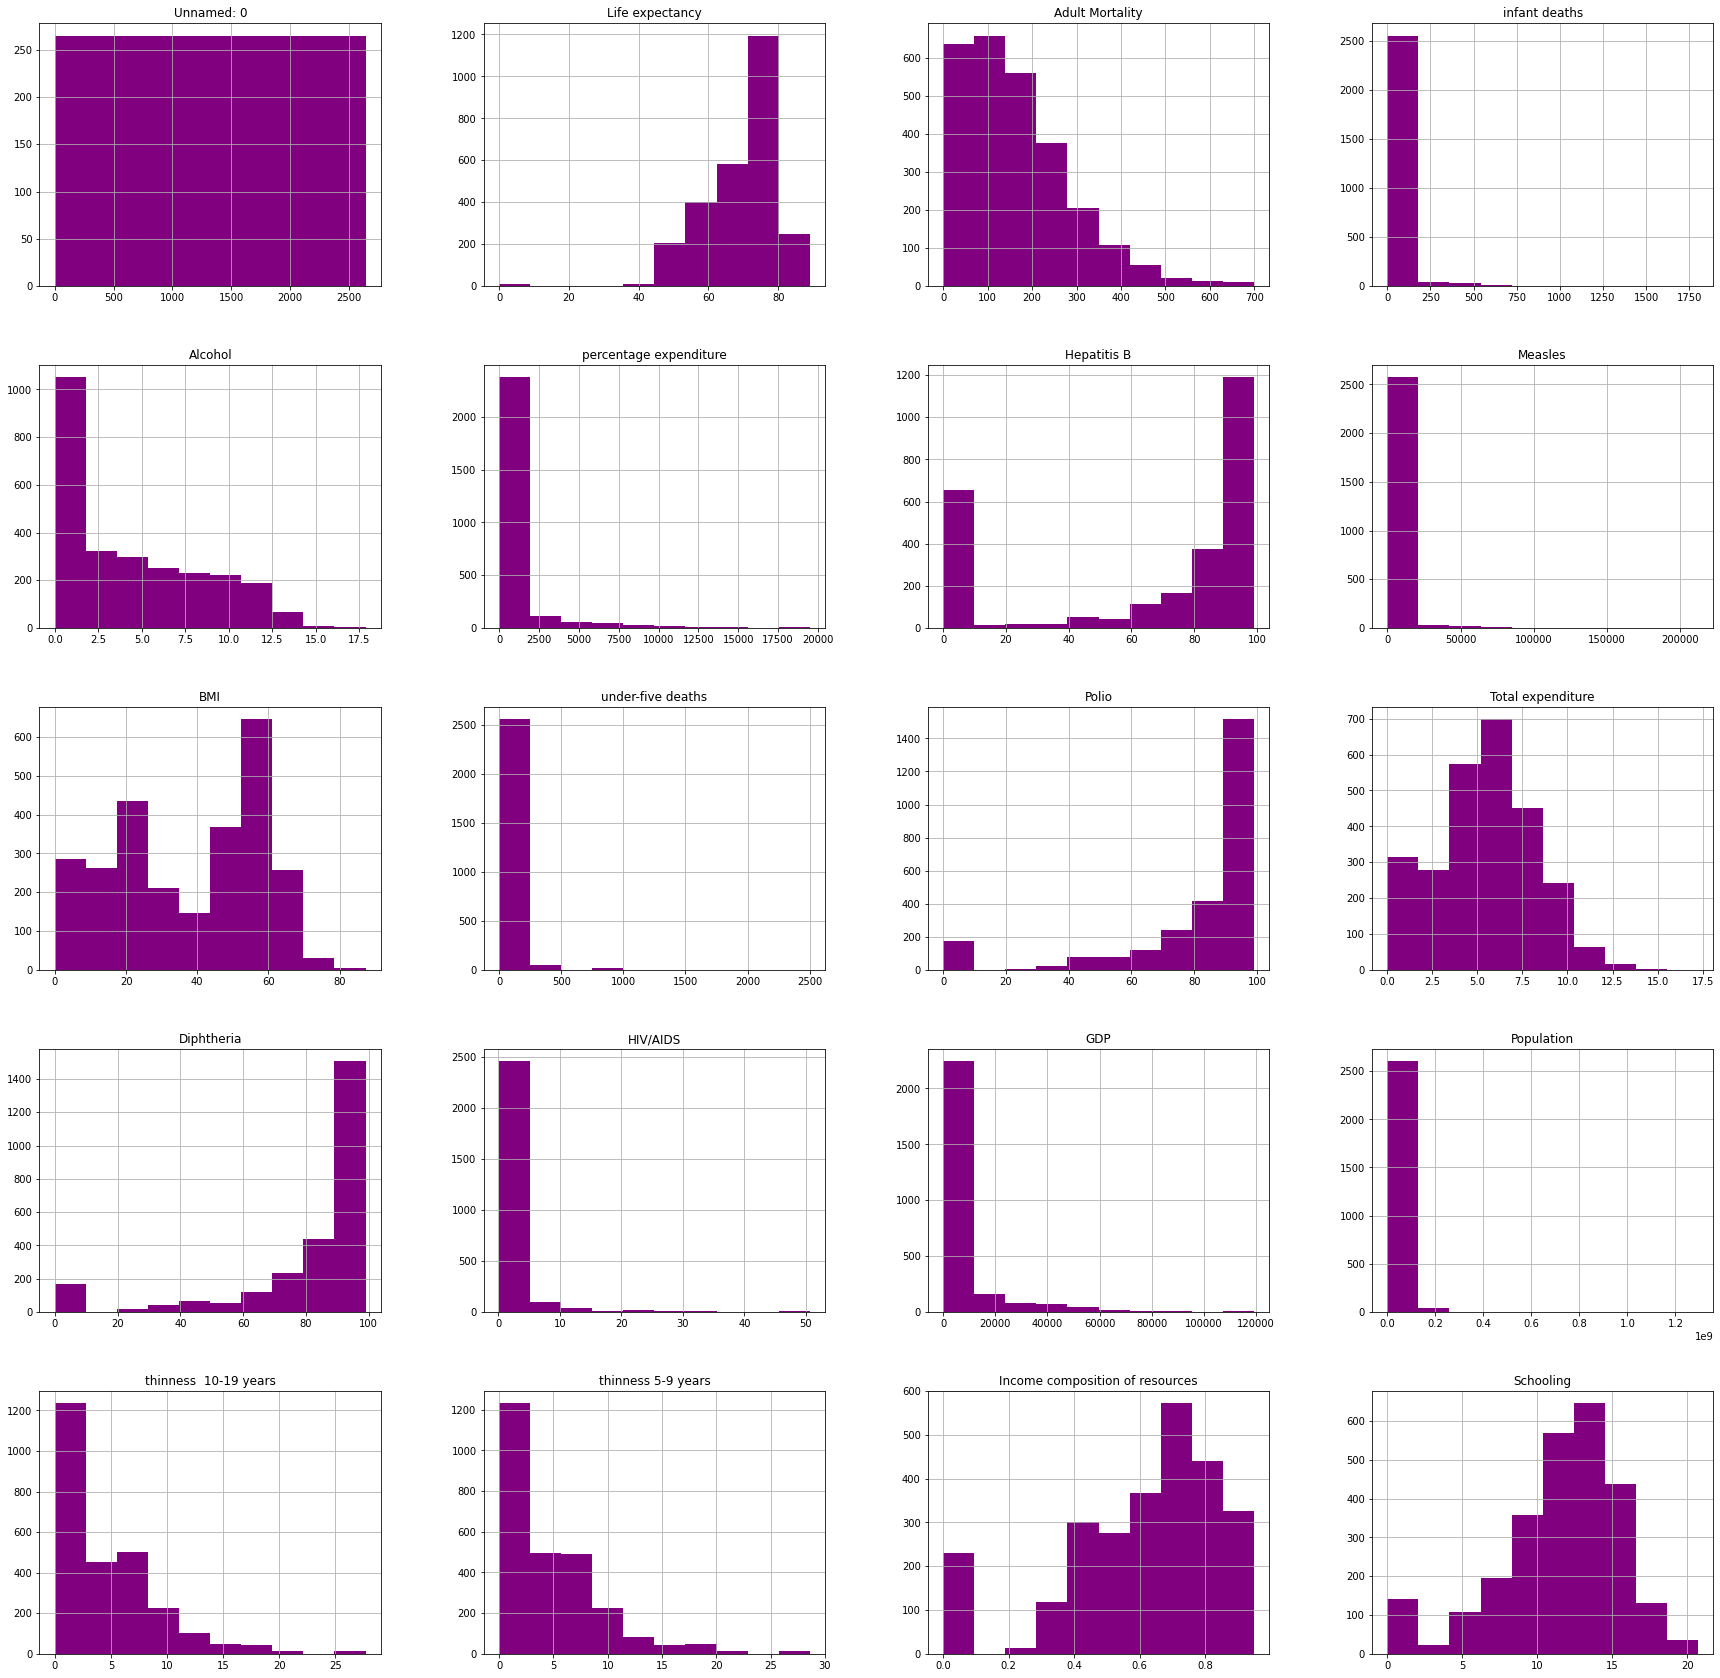

In [6]:
datos.hist(figsize=(30,30), color="purple")

Podemos ver que hay valores de cero que parecen que estan fuera de la distrubicion de las variables, vamos a revisar los boxplot de estas variables para decidir si vamos a trabajar con estos valores cero en la preparación de datos 

<AxesSubplot:>

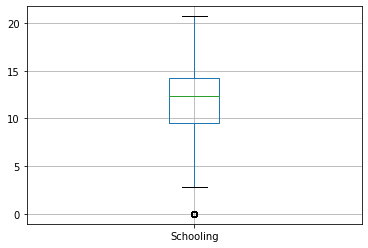

In [7]:
datos.boxplot("Schooling")

<AxesSubplot:>

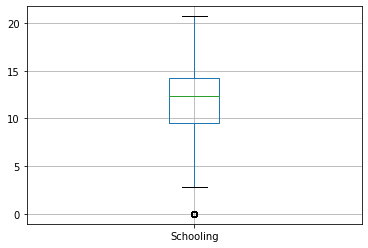

In [8]:
datos.boxplot("Schooling")

<AxesSubplot:>

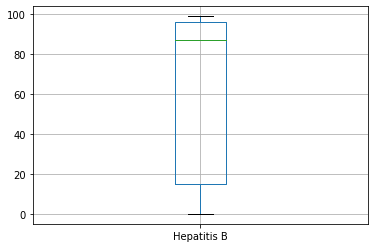

In [9]:
datos.boxplot("Hepatitis B")

## 3 Preparación de datos:
en esta etapa su equipo debe identificar y solucionar cualquier problema de inconsistencia o ruido que se pueda tener en los datos. Además, deben tener en cuenta el preprocesamiento necesario para el uso de regresiones. No olvide ejecutar un esquema de manejo de variables faltantes, identificación/manejo de datos atípicos y de normalizar en caso de ser necesario.

Como identificamos en la sección de perfilamiento, tenemos una columna "Unnamed: 0", lo cual representa una especie de ID, como esta variable no aporta valor significativo en los datos, se eliminará

In [10]:
datos=datos.drop(["Unnamed: 0"], axis =1)
datos

,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 10-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2639,72.5,147.0,0,1.08,4.783806,84.0,0,72.1,0,86.0,4.67,84.0,0.1,37.846563,1364.0,0.1,0.1,0.703,14.5
2640,72.6,145.0,0,1.10,569.625504,84.0,0,71.5,0,88.0,5.13,86.0,0.1,3392.647430,135.0,0.1,0.1,0.698,14.5
2641,72.5,146.0,0,2.05,568.869281,87.0,0,7.8,0,88.0,5.82,87.0,0.1,2932.315883,12357.0,0.1,0.1,0.698,14.5
2642,72.4,148.0,0,1.79,503.588196,89.0,0,7.1,0,89.0,5.61,88.0,0.1,2892.522663,11689.0,0.1,0.1,0.695,14.6


Ahora, como eliminamos la columna ID, volveremos a ver si hay algun dato duplicado, esto porque tenemos en cuenta que en el pandas profiling el porcentaje de duplicados pudo ser cero porque se tenía en cuenta la columna "Unnamed: 0"

In [11]:
duplicados = datos[datos.duplicated()]
print("La cantidad de datos duplicados es: ", len(duplicados))
print('El porcentaje de datos duplicados es del {perc:.2f}%'.format(perc=len(duplicados)/len(datos)*100))

La cantidad de datos duplicados es:  0
El porcentaje de datos duplicados es del 0.00%


### Revisión de rangos

Como vimos en la seccion de perfilamiento de datos, hay variables que tienen una gran cantidad de ceros que no tienen sentido según la definición de la variable. Asumimos que estos ceros corresponden a valores nulos, por lo que procedemos a hacer esta conversión

#### Conversion de ceros a NaN. 

In [12]:
cols = ["Life expectancy","BMI","GDP"]
datos[cols] = datos[cols].replace({0:np.nan,0.0:np.nan})
datos.describe()

,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 10-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2635.000000,2644.000000,2644.00000,2644.000000,2644.000000,2644.000000,2644.000000,2610.000000,2644.000000,2644.000000,2644.000000,2644.000000,2644.000000,2292.000000,2.644000e+03,2644.000000,2644.000000,2644.000000,2644.000000
mean,69.304706,162.465204,31.14410,4.328684,792.465552,65.532905,2432.922844,38.153372,43.160363,81.967095,5.431078,81.926626,1.617095,7759.055910,1.052152e+07,4.743911,4.778215,0.602879,11.482678
std,9.548259,121.186953,123.93232,4.146851,2077.768681,39.221347,11868.652439,20.009262,168.485929,24.521529,2.821982,24.502772,4.822150,14630.119902,5.680977e+07,4.467839,4.553418,0.244040,4.170684
min,36.300000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.400000,0.000000,0.000000,0.000000,0.000000,0.100000,1.681350,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,63.000000,73.000000,0.00000,0.407500,7.044565,14.750000,0.000000,19.300000,0.000000,78.000000,3.677500,78.000000,0.100000,472.871238,1.285900e+04,1.500000,1.500000,0.473000,9.500000
50%,72.200000,143.000000,2.00000,3.225000,70.648787,87.000000,14.000000,43.550000,3.000000,93.000000,5.550000,93.000000,0.100000,1823.610128,6.227965e+05,3.200000,3.200000,0.668000,12.300000
75%,75.800000,226.250000,18.00000,7.495000,485.959559,96.000000,329.750000,56.000000,23.000000,97.000000,7.372500,97.000000,0.800000,6423.954117,5.194999e+06,7.200000,7.300000,0.781000,14.200000
max,89.000000,699.000000,1800.00000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,99.000000,17.240000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


### Revisión de valores fuera de rango 

Sabemos por la seccion anterior que las variables fuera de rango son:
* infant deaths  
* Measles
* under-five deaths
* HIV/AIDS
* Population
* BMI
* GDP

Comenzaremos con la variable infant deaths, por el diccionario sabemos que indica el Número de infantes que mueren por cada 1000 habitantes. 
Sabemos que el máximo valor que puede tomar esta variable es mil, por lo que miraremos cuantos datos se salen de este máximo 

#### Variable infant deaths

In [13]:
fuera_rango_infant_deaths=len(datos[datos["infant deaths"]>1000])
porcentaje= fuera_rango_infant_deaths/datos.shape[0] *100
print('Hay : {}'.format(fuera_rango_infant_deaths), "datos fuera del rango, lo cual representa el {:.2f}%".format(porcentaje), "de datos.")   

Hay : 13 datos fuera del rango, lo cual representa el 0.49% de datos.


Como el porcentaje es muy pequeño, procederemos a eliminar los datos fuera de rango

In [14]:
datos.drop(datos[datos["infant deaths"]>1000].index, inplace=True)
fuera_rango_infant_deaths=len(datos[datos["infant deaths"]>1000])
porcentaje= fuera_rango_infant_deaths/datos.shape[0] *100
print('Hay : {}'.format(fuera_rango_infant_deaths), "datos fuera del rango, lo cual representa el {:.2f}%".format(porcentaje), "de datos.")   

Hay : 0 datos fuera del rango, lo cual representa el 0.00% de datos.


#### Variable Measles

Para la variable Measles pasa igual que la anterior variable, pues hay datos que se pasan de mil. Revisaremos cuantos datos se pasan de mil

In [15]:
fuera_rango_Measles=len(datos[datos["Measles"]>1000])
porcentaje= fuera_rango_Measles/datos.shape[0] *100
print('Hay : {}'.format(fuera_rango_Measles), "datos fuera del rango, lo cual representa el {:.2f}%".format(porcentaje), "de datos.")   

Hay : 446 datos fuera del rango, lo cual representa el 16.95% de datos.


Estos datos los convertiremos a nulos y los manejaremos mas adelante 

In [16]:
datos["Measles"] = datos["Measles"].apply( lambda x : x if x<=1000 else np.nan )
fuera_rango_Measles=len(datos[datos["Measles"]>1000])
porcentaje= fuera_rango_Measles/datos.shape[0] *100
print('Hay : {}'.format(fuera_rango_Measles), "datos fuera del rango, lo cual representa el {:.2f}%".format(porcentaje), "de datos.")   

Hay : 0 datos fuera del rango, lo cual representa el 0.00% de datos.


#### Variable under-five deaths

Para la variable under-five deaths pasa igual que la anterior variable, pues hay datos que se pasan de mil. Revisaremos cuantos datos se pasan de mil

In [17]:
fuera_rango_under_five_deaths=len(datos[datos["under-five deaths"]>1000])
porcentaje= fuera_rango_under_five_deaths/datos.shape[0] *100
print('Hay : {}'.format(fuera_rango_under_five_deaths), "datos fuera del rango, lo cual representa el {:.2f}%".format(porcentaje), "de datos.")   

Hay : 3 datos fuera del rango, lo cual representa el 0.11% de datos.


Como el porcentaje es muy pequeño, procederemos a eliminar los datos fuera de rango

In [18]:
datos.drop(datos[datos["under-five deaths"]>1000].index, inplace=True)
fuera_rango_under_five_deaths=len(datos[datos["under-five deaths"]>1000])
porcentaje= fuera_rango_under_five_deaths/datos.shape[0] *100
print('Hay : {}'.format(fuera_rango_under_five_deaths), "datos fuera del rango, lo cual representa el {:.2f}%".format(porcentaje), "de datos.")   

Hay : 0 datos fuera del rango, lo cual representa el 0.00% de datos.


#### Variable BMI

Continuaremos con la variable BMI, por el perflamiento sabemos que esta comprende un rango entre 0 y 87.3. Sin embargo, al investigar cuales valores tienen sentido para esta variable, encontramos que se debe tener un rango entre 10 y 60, por lo que ese será el rango que revisameremos en este punto. 

In [19]:
fuera_rango_BMI=len(datos[datos["BMI"]>60])+len(datos[datos["BMI"]<10])
porcentaje= fuera_rango_BMI/datos.shape[0] *100
print('Hay : {}'.format(fuera_rango_BMI), "datos fuera del rango, lo cual representa el {:.2f}%".format(porcentaje), "de datos.")   

Hay : 555 datos fuera del rango, lo cual representa el 21.12% de datos.


Convertiremos estos datos a nulos y los manejaremos mas adelante 

In [20]:
datos["BMI"] = datos["BMI"].apply( lambda x : x if (x<=60 and x>=10) else np.nan )
fuera_rango_BMI=len(datos[datos["BMI"]>1000])
porcentaje= fuera_rango_BMI/datos.shape[0] *100
print('Hay : {}'.format(fuera_rango_BMI), "datos fuera del rango, lo cual representa el {:.2f}%".format(porcentaje), "de datos.")   

Hay : 0 datos fuera del rango, lo cual representa el 0.00% de datos.


#### Variable GDP

Como vimos en el perfilaminto, esta variable tiene datos con cero, lo cual no encontramos lógico según la lógica y el sentido que tiene esta variable. Investigando, encontramos que el pais con menor GDP es de 200, asi que revisaremos cuantos valores son  inferiores a este número.

In [21]:
fuera_rango_GDP=len(datos[datos["GDP"]<200])
porcentaje= fuera_rango_GDP/datos.shape[0] *100
print('Hay : {}'.format(fuera_rango_GDP), "datos fuera del rango, lo cual representa el {:.2f}%".format(porcentaje), "de datos.")   

Hay : 277 datos fuera del rango, lo cual representa el 10.54% de datos.


Convertiremos estos datos a nulos y los manejaremos mas adelante 

In [22]:
datos["GDP"] = datos["GDP"].apply( lambda x : x if x>=200 else np.nan )
fuera_rango_GDP=len(datos[datos["GDP"]<200])
porcentaje= fuera_rango_GDP/datos.shape[0] *100
print('Hay : {}'.format(fuera_rango_GDP), "datos fuera del rango, lo cual representa el {:.2f}%".format(porcentaje), "de datos.")   

Hay : 0 datos fuera del rango, lo cual representa el 0.00% de datos.


#### Variable Population

Como vimos en el pandas profiling, vemos que el 20% de los registros están en 0. Como no tiene sentido tener una población de 0, asumimos que este valor se refiere a un valor nulo, y lo reemplazamos en el data set. 

In [23]:
#Cambio de 0 a nulos
datos["Population"] = datos["Population"].replace({0:np.nan})
#Revision de valores fuera de rango 
fuera_rango_Population=len(datos[datos["Population"]<800])
porcentaje= fuera_rango_Population/datos.shape[0] *100
print('Hay : {}'.format(fuera_rango_Population), "datos fuera del rango, lo cual representa el {:.2f}%".format(porcentaje), "de datos.")   

Hay : 29 datos fuera del rango, lo cual representa el 1.10% de datos.


Igualmente, verificando que el país con menos habitantes tiene 800 personas, y viendo que la cantidad de registros un valor menor a 800 es 1.1%, procedemos a eliminar  estos registros.

In [24]:
datos.drop(datos[datos["Population"]<800].index, inplace=True)
fuera_rango_Population=len(datos[datos["Population"]<800])
porcentaje= fuera_rango_Population/datos.shape[0] *100
print('Hay : {}'.format(fuera_rango_Population), "datos fuera del rango, lo cual representa el {:.2f}%".format(porcentaje), "de datos.")   

Hay : 0 datos fuera del rango, lo cual representa el 0.00% de datos.


#### Variable percentage expenditure

Analizaremos esta variable teniendo en cuenta que esta representa un porcentaje, el cual comprende de 0 a 100

In [25]:
fuera_rango_percentage_expenditure=len(datos[datos["percentage expenditure"]<100])
porcentaje= fuera_rango_percentage_expenditure/datos.shape[0] *100
print('Hay : {}'.format(fuera_rango_percentage_expenditure), "datos fuera del rango, lo cual representa el {:.2f}%".format(porcentaje), "de datos.")   

Hay : 1418 datos fuera del rango, lo cual representa el 54.56% de datos.


Como observamos en el perfilamiento, esta variable tiene alrededor de un 54% de datos no válidos, es decir, mayores a 100, ya que la variable corresponde a un porcentaje. Igualmente, en el Pandas Profiling podemos observar que esta variable tiene una alta correlación con la variable GDP. Por estas dos razones anteriores, concluimos que la variable puede ser eliminada sin alterar el desempeño del modelo que vamos a crear

In [26]:
datos=datos.drop(["percentage expenditure"], axis =1)
datos

,Life expectancy,Adult Mortality,infant deaths,Alcohol,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 10-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,65.0,263.0,62,0.01,65.0,NaN,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,59.9,271.0,64,0.01,62.0,492.0,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,59.9,268.0,66,0.01,64.0,430.0,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,59.5,272.0,69,0.01,67.0,NaN,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,59.2,275.0,71,0.01,68.0,NaN,17.2,97,68.0,7.87,68.0,0.1,NaN,2978599.0,18.2,18.2,0.454,9.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2638,72.8,142.0,0,1.24,82.0,0.0,NaN,0,84.0,4.59,82.0,0.1,3547.599750,14137.0,0.1,0.1,0.707,14.4
2639,72.5,147.0,0,1.08,84.0,0.0,NaN,0,86.0,4.67,84.0,0.1,NaN,1364.0,0.1,0.1,0.703,14.5
2641,72.5,146.0,0,2.05,87.0,0.0,NaN,0,88.0,5.82,87.0,0.1,2932.315883,12357.0,0.1,0.1,0.698,14.5
2642,72.4,148.0,0,1.79,89.0,0.0,NaN,0,89.0,5.61,88.0,0.1,2892.522663,11689.0,0.1,0.1,0.695,14.6


### Manejo de nulos 

In [27]:
datos.isnull().sum(axis = 0)

Life expectancy                      8
Adult Mortality                      0
infant deaths                        0
Alcohol                              0
Hepatitis B                          0
Measles                            441
BMI                                583
under-five deaths                    0
Polio                                0
Total expenditure                    0
Diphtheria                           0
HIV/AIDS                             0
GDP                                626
Population                         540
thinness  10-19 years                0
thinness 5-9 years                   0
Income composition of resources      0
Schooling                            0
dtype: int64

Después de los pasos anteriores, en este punto encontramos que las variables Measles, BMI, GDP y Population tienen una cantidad cercana de valores nulos. Procedemos a reemplazar estas casillas por el valor de la media de cada columna. 

Adicional tenemos la variable Life expentancy, la cual manejaremos a continuación

#### Variable Life expectancy

Como mencionamos en el perfilamiento, no tiene sentido que la expectativa de vida de un país sea 0, por lo que procedemos a eliminar los registros en los que Life Expectancy sea 0, teniendo en cuenta también que son únicamente 8 registros

In [28]:
datos["Life expectancy"].dropna()
datos["Life expectancy"].isnull().sum(axis = 0)

8

#### Demás variables con nulos 

Reemplazaremos con la media como se mecionó anteriormente 

In [29]:
datos=datos.fillna(datos.mean())
datos.isnull().sum(axis = 0)

Life expectancy                    0
Adult Mortality                    0
infant deaths                      0
Alcohol                            0
Hepatitis B                        0
Measles                            0
BMI                                0
under-five deaths                  0
Polio                              0
Total expenditure                  0
Diphtheria                         0
HIV/AIDS                           0
GDP                                0
Population                         0
thinness  10-19 years              0
thinness 5-9 years                 0
Income composition of resources    0
Schooling                          0
dtype: int64

## 2. Identificación de variables a utilizar  
su equipo debe identificar las variables más relevantes que puedan utilizarse en el proceso de estimación.

### Búsqueda de relaciones entre variables (diagramas de dispersión)

Para realizar esta seccion, primero identificaremos nuestra variable independiente, la cual será **Life expectancy** y veremos la relacion de las demas variables con esta 

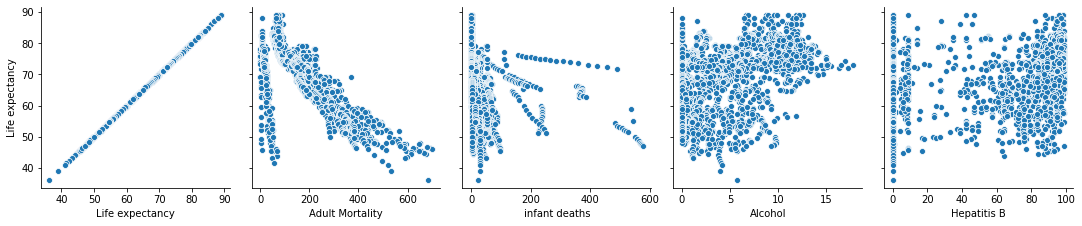

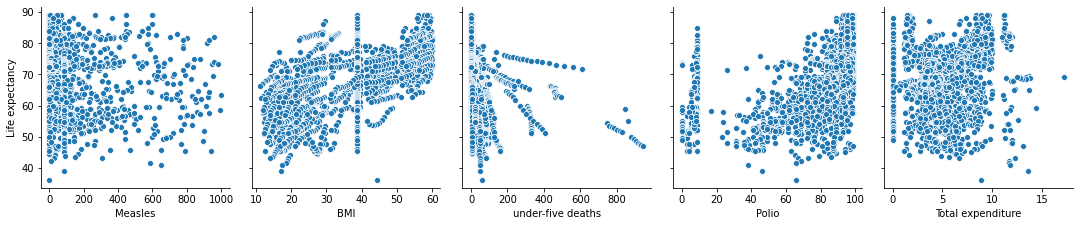

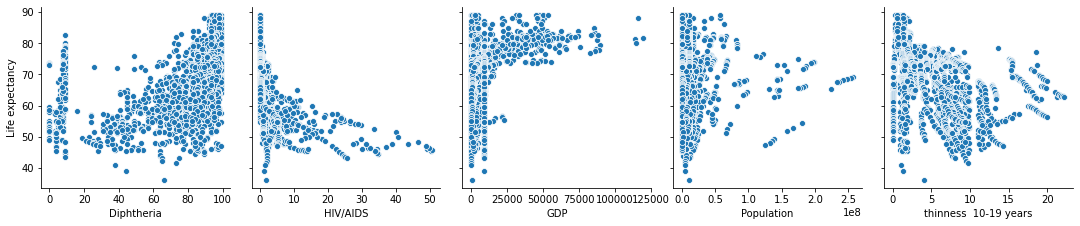

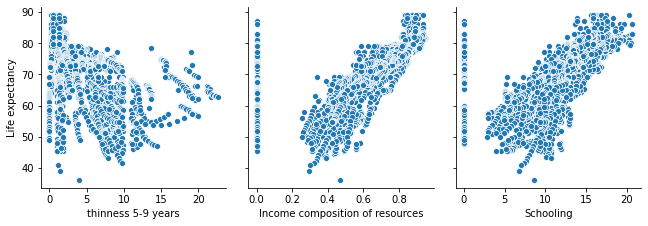

In [30]:
sns.pairplot(datos, height=3, y_vars = 'Life expectancy', x_vars = datos.columns[0:5], kind='scatter')
sns.pairplot(datos, height=3, y_vars = 'Life expectancy', x_vars = datos.columns[5:10], kind='scatter')
sns.pairplot(datos, height=3, y_vars = 'Life expectancy', x_vars = datos.columns[10:15], kind='scatter')
sns.pairplot(datos, height=3, y_vars = 'Life expectancy', x_vars = datos.columns[15:], kind='scatter')

Con estos gráficos podemos encontrar que las variables que **no** parecen tener una relación con la variable de interés son :
* Alcohol
* Hepatitis B
* Measles
* Total expenditure
* Population

Revisaremos la matriz de correlacion para asegurarnos de esta afirmación

 ### Búsqueda de relaciones entre variables (Matriz de correlaciones)

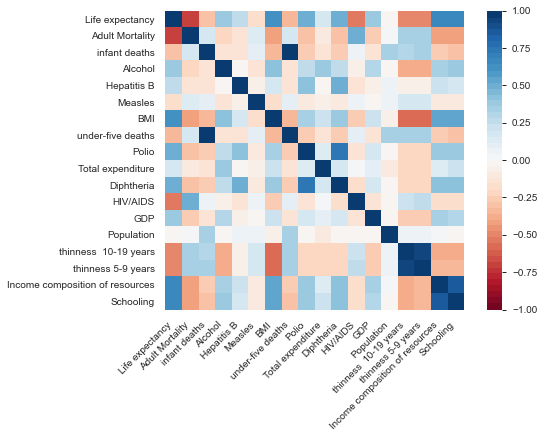

In [31]:
corr = datos.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.color_palette("RdBu",50),
    square=True,
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

De esta matriz de correlacion podemos destacar que hay variables que estan relacionadas entre ellas. Algunas destacables son:
* under-five deaths con infant deaths
* Scholing con Income composition of resources
* Life expentancy con Adult Mortality (inversamente relacionadas)
* BMI con thinness  10-19 years y thinness 5-9 years

Para asegurarnos de que estos valores estan altamente relacionados, revisaremos sus coeficientes de correlación

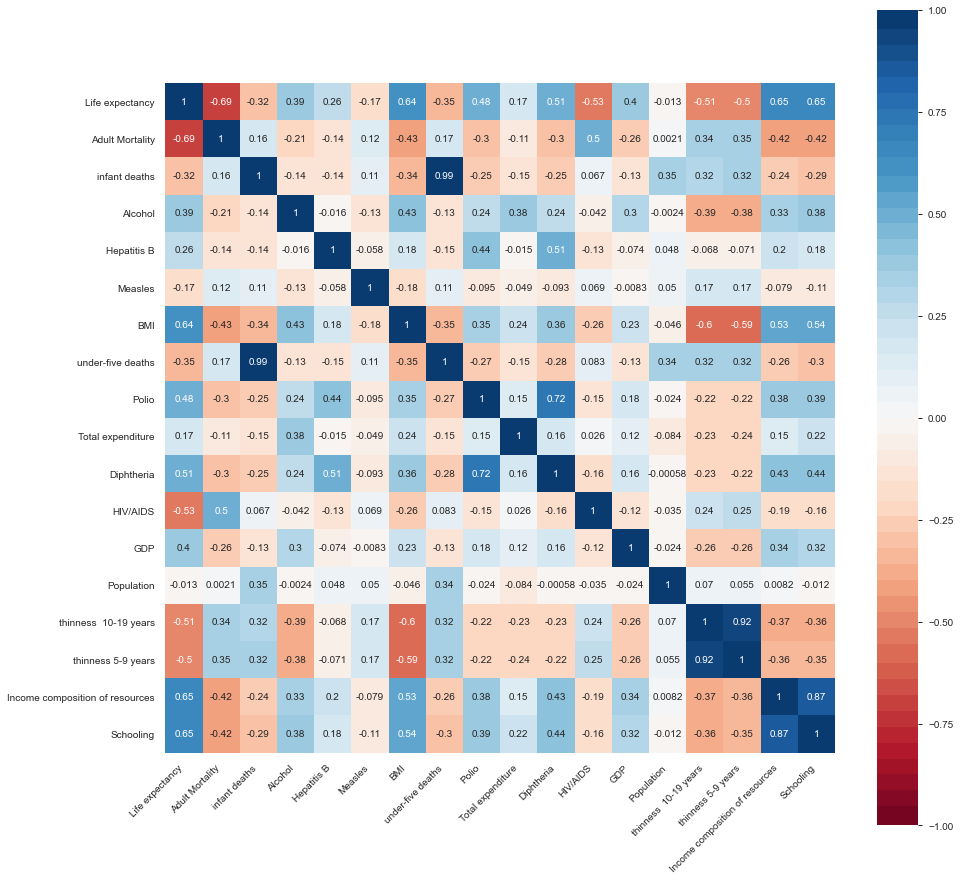

In [32]:
plt.figure(figsize =(15,15))
corr = datos.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.color_palette("RdBu",50),
    square=True,
    annot = True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Con esto, podemos ver que las variables con alta correlacion(>0.6 o <-0.6) entre ellas y que no tienen que ver con la variable de interés son: 
* under-five deaths y infant deaths (con 0.99)
* thinness  10-19 years y thinness 5-9 years (con 0.92)
* Income composition of resources y Schooling (con 0.87)
* Polio y Diphtheria (con 0.72)
* BMI con thinness  10-19 years (con -0.6)

Ahora, respecto a las correlaciones entre la variable de interés (Life expectancy) y las demás, podemos ver que las que tienen una correlación muy pequeña (entre 0.2  y -0.2) son :
* Measles
* Total expenditure 
* Population

Podemos ver que la variable Alcohol y Hepatitis B si tienen una relación con la variable de interés (contrario a lo que habíamos intuido con los diagramas de dispersión)



Despues de estos 2 análisis, escojeremos todas las variables excepto **Measles**, **Total expenditure** y **Population** por su baja correlación con la variable Life expectancy. Adicional a esto, para las variables que estan correlacionadas entre ellas se escojerá solo una de ellas. El criterio de decisión será la que tenga la correlacion mas signitiva (mas positiva o mas negativa) con la variable de interés. En caso de que sea el mismo valor, se escoje cualquiera. Al aplicar esto, obtenemos:

* under-five deaths y infant deaths-> nos quedamos con: **under-five deaths**
* thinness 10-19 years y thinness 5-9 years -> nos quedamos con: **thinness 10-19 year**
* BMI con thinness 10-19 years-> Nos quedamos con **BMI**
* Income composition of resources y Schooling -> Escogemos cualquiera 
* Polio y Diphtheria -> nos quedamos con:**Diphtheria**


Esto ultimo se realiza con el fin de evitar colinealidad.
Nota: Al final no tomaremos la variable thinness 10-19 year, porque esta tambien está correlacionada con BMI y BMI, en comparación, tiene una correlación mayor con la variable de interés

## 4. Modelamiento:
A partir de las variables identificadas anteriormente, se debe plantear una regresión que estime la variable objetivo y medir su desempeño.


### Modelo 1 

In [33]:
# Se usa un transformador para seleccionar unicamente las columnas que se quieren usar
selected_cols = ['Adult Mortality', 'Alcohol','Hepatitis B', 'BMI', 'under-five deaths', 
       'Diphtheria', 'HIV/AIDS', 'GDP','Income composition of resources']

#Debido a que el algoritmo que usaremos para la construcción del modelo es Regresión Linear, 
#debemos realizar escalamiento de los datos, por lo que procedemos con lo siguiente
pre = [('initial',ColumnTransformer([("selector", 'passthrough',selected_cols)])),
       ('scaler', MinMaxScaler()),
       ('imputer', SimpleImputer(missing_values = np.nan, strategy='mean')),
      ]
# Modelo
model = [('model', LinearRegression())]

# Se declara el pipeline
pipeline1 = Pipeline(pre+model)

In [34]:
X = datos.drop('Life expectancy', axis = 1)
y = datos['Life expectancy']

p1 = pipeline1.fit(X,y)

In [35]:
# Visualizamos la regresion lineal en cada dimension
def graficar_en_cada_dimension(p,selected_cols ):
    f, axs = plt.subplots( 3,len(selected_cols), sharey=True, figsize = (15,13))
    fila=0
    j=0
    for i in range(len(selected_cols)):
        pos_col = i
        col = selected_cols[pos_col]

        # Variable x
        x = X[col]
        # Pendiente
        m = p['model'].coef_[pos_col]
        # Interceto
        b = p['model'].intercept_
        if j ==9: 
            j=0
            fila +=1
        axs[fila, j].plot(x, y, 'o', alpha = 0.1)
        axs[fila, j].plot(x, x*m + b)
        axs[fila, j].set_title(col)
        j+=3

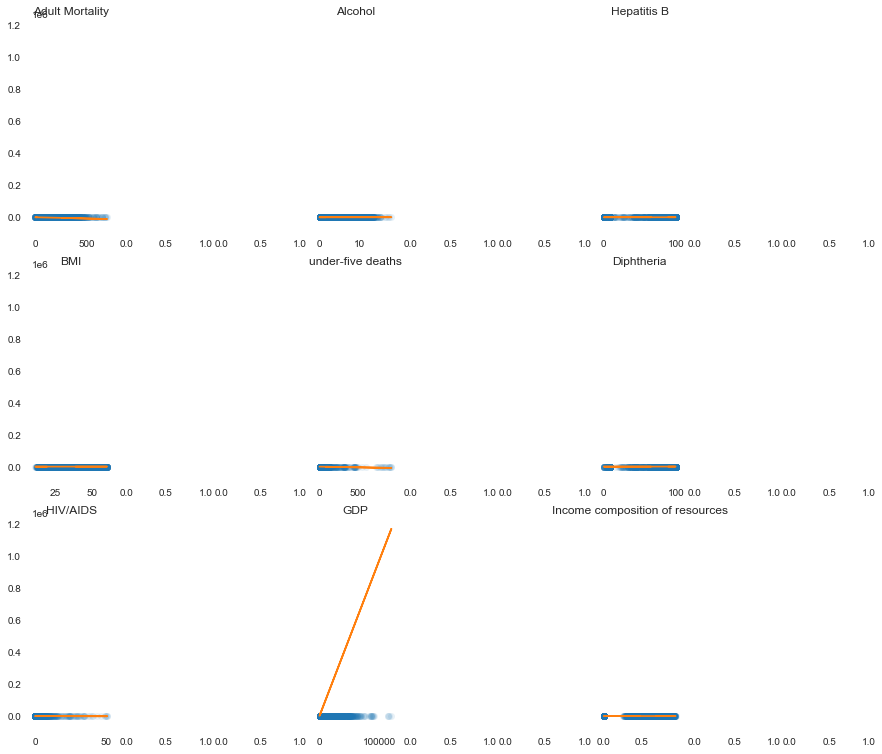

In [36]:
graficar_en_cada_dimension(p1,selected_cols )

Ahora, revisaremos cuales son las variables significativas del modelo, para saber si debemos realizar otro. Para esto, realizaremos la prueba t-test 

La prueba t de Student o t-test, con las siguientes hipótesis sobre los coeficientes, indica que:

H0: wi = 0, es decir, no hay una relación lineal entre la variable dependiente y la independiente (hipótesis nula).

Ha: wi ≠ 0, es decir, sí existe una relación lineal entre ambas variables.

El p-valor (en inglés p-value) del coeficiente verifica entonces la hipótesis nula de la siguiente forma:
Si el p-valor es menor o igual que el nivel de significancia seleccionado, entonces se puede afirmar que los datos suministran suficiente evidencia para rechazar la hipótesis nula. Es decir, cambios en la variable independiente estarán asociados con cambios en la variable dependiente y esta relación es estadísticamente significativa, por lo que la variable independiente será importante para el modelo de regresión.
Si el p-valor es mayor que el nivel de significancia, entonces no hay suficiente evidencia en los datos para rechazar la hipótesis nula y concluir que w1 es significativamente diferente de 0.

Por otra parte, el valor de un coeficiente determina cuánto aumenta o se reduce el valor promedio de la variable dependiente cuando la independiente cambia por una unidad. El signo del coeficiente indica si la relación es positiva o negativa.


Podemos sacar un reporte que nos va a permitir analizar estadísticos del modelo. En este caso, exigimos p-value = 0.1. Tal que rechazamos todas aquellas variables cuyo p-value sea mayor a dicho valor.

In [37]:
# Ajustar el modelo para ver el reporte
x=datos[selected_cols]
model = sm.OLS(y, x).fit() ## sm.OLS(output, input)
# Mostrar las estadísticas del modelo
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:        Life expectancy   R-squared (uncentered):                   0.974
Model:                            OLS   Adj. R-squared (uncentered):              0.974
Method:                 Least Squares   F-statistic:                          1.079e+04
Date:                Sun, 20 Mar 2022   Prob (F-statistic):                        0.00
Time:                        11:33:25   Log-Likelihood:                         -9983.6
No. Observations:                2599   AIC:                                  1.999e+04
Df Residuals:                    2590   BIC:                                  2.004e+04
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Adult Mortality                     0.0398      0.002     20.629      0.000       0.036       0.044
Alcohol                            -0.1144      0.062     -1.857      0.063      -0.235       0.006
Hepatitis B                         0.0041      0.007      0.606      0.545      -0.009       0.017
BMI                                 0.5591      0.019     29.857      0.000       0.522       0.596
under-five deaths                   0.0337      0.002     13.687      0.000       0.029       0.039
Diphtheria                          0.3075      0.010     29.373      0.000       0.287       0.328
HIV/AIDS                           -0.5360      0.053    -10.059      0.000      -0.641      -0.432
GDP                                 0.0001   1.83e-05      6.651      0.000    8.58e-05       0.000
Income composition of resources    21.7204      1.146     18.952      0.000      19.473      23.968
==============================================================================
Omnibus:                      215.750   Durbin-Watson:                   0.698
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              299.224
Skew:                           0.679   Prob(JB):                     1.06e-65
Kurtosis:                       3.957   Cond. No.                     8.35e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 8.35e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Según la prueba obtenida, con una confianza del 90%, la variable Hepatitis B no es significativa, por lo que, para esta variable se acepta la hiótesis nula.
Por lo anterior, realizaremos otro modelo, quitando dicha variable

### Modelo 2

In [38]:
selected_cols2 = ['Adult Mortality', 'Alcohol', 'BMI', 'under-five deaths', 
       'Diphtheria', 'HIV/AIDS','Income composition of resources']
#Debido a que el algoritmo que usaremos para la construcción del modelo es Regresión Linear, debemos realizar escalamiento de los datos, por lo que procedemos con lo siguiente
pre = [('initial',ColumnTransformer([("selector", 'passthrough',selected_cols2)])),
       ('scaler', MinMaxScaler()),
       ('imputer', SimpleImputer(missing_values = np.nan, strategy='mean')),
      ]
# Modelo
model = [('model', LinearRegression())]

# Se declara el pipeline
pipeline2 = Pipeline(pre+model)
p2 = pipeline2.fit(X,y)

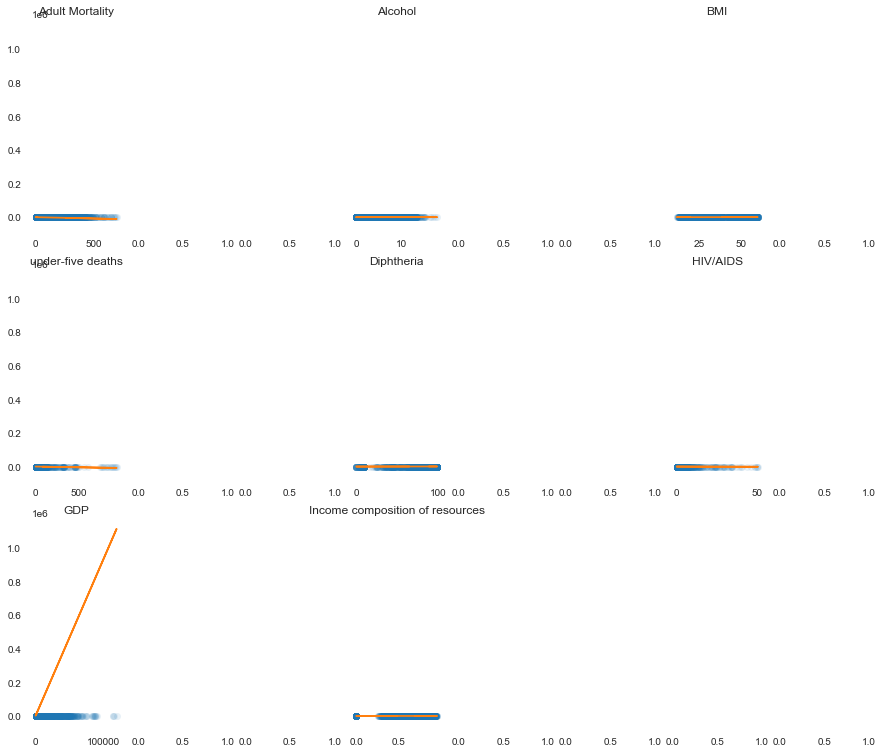

In [39]:
graficar_en_cada_dimension(p2,selected_cols2 )

#### prueba t-student

In [40]:
# Ajustar el modelo para ver el reporte
x=datos[selected_cols2]
model = sm.OLS(y, x).fit() ## sm.OLS(output, input)
# Mostrar las estadísticas del modelo
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:        Life expectancy   R-squared (uncentered):                   0.974
Model:                            OLS   Adj. R-squared (uncentered):              0.974
Method:                 Least Squares   F-statistic:                          1.214e+04
Date:                Sun, 20 Mar 2022   Prob (F-statistic):                        0.00
Time:                        11:33:31   Log-Likelihood:                         -9983.8
No. Observations:                2599   AIC:                                  1.998e+04
Df Residuals:                    2591   BIC:                                  2.003e+04
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Adult Mortality                     0.0399      0.002     20.642      0.000       0.036       0.044
Alcohol                            -0.1195      0.061     -1.958      0.050      -0.239       0.000
BMI                                 0.5597      0.019     29.927      0.000       0.523       0.596
under-five deaths                   0.0337      0.002     13.678      0.000       0.029       0.039
Diphtheria                          0.3109      0.009     35.103      0.000       0.294       0.328
HIV/AIDS                           -0.5378      0.053    -10.109      0.000      -0.642      -0.433
GDP                                 0.0001   1.81e-05      6.640      0.000    8.45e-05       0.000
Income composition of resources    21.7380      1.146     18.976      0.000      19.492      23.984
==============================================================================
Omnibus:                      219.663   Durbin-Watson:                   0.701
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              306.302
Skew:                           0.686   Prob(JB):                     3.07e-67
Kurtosis:                       3.972   Cond. No.                     8.35e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 8.35e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Con estos resultados, se puede decir que, con una significancia del 10%, todas las variables son significativas para la variable de interes, por lo tanto se rechaza la hipótesis nula

## 5.Evaluación cuantitativa:
A partir de las métricas seleccionadas para comparar y seleccionar el mejor modelo, explicar el resultado obtenido desde el punto de vista cuantitativo y contestar:

¿Su equipo recomienda instalar el modelo de estimación en producción o es mejor continuar usando expertos para la tarea?
En caso de no recomendar el uso de un modelo de regresión ¿Que otras posibilidades tiene la empresa?¿Hacia donde debe seguir con esta tarea?

 En esta sección se utilizan las siguientes métricas

1. Root-Mean-Squared-Error(RMSE). Raiz del Error medio cuadrático
2. Mean-Absolute-Error(MAE). Error absoluto medio
3. R² or Coeficiente de determinación.

In [41]:
datos_test=pd.read_csv('datos_recientes.csv')
datos_test.describe()
X_test = datos_test.copy()
#y_test = datos_test['Life expectancy']

In [43]:
# Se obtienen las predicciones del modelo sobre el conjunto de entrenamiento.
y_pred1 = p1.predict(X)
y_pred2 = p2.predict(X)


### Coeficiente de Determinación $R^2$

Este valor indica que porcentaje de la varianza en la variable objetivo se puede explicar con las variables observadas. Este se define como:
$$ R^2 =  1 - \frac{\sum_{i=1}^{n} (y_i - f_i)^2}{\sum_{i=1}^{n} (y_i - \hat{y})^2}$$

donde $y_i$ es el elemento $i$ de la varaible objetivo, $f_i$ el elemento i de los valores predecidos y:

$$ \hat{y} = \frac{1}{n} \sum_{i=1}^{n} y_{i} $$


In [44]:
r2_1=r2_score(y, y_pred1)
r2_2= r2_score(y, y_pred2)
print ("Para el modelo 1, el r^2 es de:",r2_1)
print ("Para el modelo 2, el r^2 es de:",r2_2)

Para el modelo 1, el r^2 es de: 0.781108985438729
Para el modelo 2, el r^2 es de: 0.7801665803393747


Podemos ver que ambos modelos estiman bastante bien a la variable real, ambos modelos explican aproximadamente el 78% de la variable de interés. Por una poca diferencia, el modelo 1 tiene el coeficiente más alto, por lo que explicaría un poco más la variable de interés 

### Root-Mean-Square Error (RMSE) 
La segunda medida es la raiz del error cuadrático medio, definido como:

$$ RSME = \sqrt{\frac{\sum_{i=1}^{n} (y_i - f_i)^2}{n}} $$

In [45]:
# Se obtienen las métricas a partir de la predicción y la base de evaluación (valores reales).
rmse1=mean_squared_error(y, y_pred1, squared=False)
rmse2=mean_squared_error(y, y_pred2, squared=False)
print ("Para el modelo 1, el RMSE es de:",rmse1)
print ("Para el modelo 2, el RMSE es de:",rmse2)

Para el modelo 1, el RMSE es de: 4.483808038355103
Para el modelo 2, el RMSE es de: 4.493449880409171


Podemos que estos resultados son muy parecidos. Sin embargo, evidenciamos que el modelo 1 presenta un RMS menor, lo cual significa que este tiene un mejor ajuste que el segundo modelo

### Mean-Absolute-Error(MAE). 
Error absoluto medio

In [46]:
mae1=mean_absolute_error(y, y_pred1)
mae2=mean_absolute_error(y, y_pred2)
print ("Para el modelo 1, el MAE es de:",rmse1)
print ("Para el modelo 2, el MAE es de:",rmse2)

Para el modelo 1, el MAE es de: 4.483808038355103
Para el modelo 2, el MAE es de: 4.493449880409171


Para ambos modelos podemos ver que, en promedio la "distancia" del pronóstico de Life expectancy desde el valor verdadero de esta variable es aproximadamente 4.4. Con esto, podemos ver que el modelo 2 representa en promedio una distancia un poco mas larga que el modelo 1. Por lo que nuevamente, el modelo 1 destaca por una diferencia mínima respecto al modelo 2

El resumen de los resultados de ambos modelos se puede ver a continuación

In [47]:
data={"MODELO":[1,2],"RMSE":[rmse1, rmse2],"MAE":[mae1, mae2], "R²":[r2_1,r2_2]}
df = pd.DataFrame(data)  
df  

,MODELO,RMSE,MAE,R²
0,1,4.483808,3.407027,0.781109
1,2,4.493450,3.413650,0.780167


Ahora, respondiendo las preguntas planteadas ¿Su equipo recomienda instalar el modelo de estimación en producción o es mejor continuar usando expertos para la tarea? 
    
Realizamos la comparacion entre los dos modelos y pudimos ver que ambos estimarían bien la variable de interes (Siendo, por muy pocas diferencias, mejor el modelo 1). Sin embargo, debemos tener en cuenta que el modelo 1 tiene una variable extra, lo cual puede hacer que el modelo sea mas complejo que el 2 y que además afecte negativamente los grados de libertad del modelo. Como los cambios entre el modelo 1 y 2 no son muy significativos, para continuar con la evaluación cualitativa, se escojerá el **modelo 2**.  
    Pudimos observar un valor pequeño respecto a los errores (RMSE y MAE) y un gran ajuste al mirar $R^2$

## 6.Evaluación cualitativa
responder a la pregunta del negocio 	¿Qué obtuvieron con el ejercicio de regresión? ¿Cuales son las variables mas influyentes y que tan confiables son los resultados?
- Validación de supuestos: realice los ajustes necesarios para que su modelo cumpla con las suposiciones necesarias para la inferencia estadística con regresiones.
- Interpretación de los coeficientes: realice una interpretación de los coeficientes de la regresión, identificando los mas relevantes para la tarea y como afectan la variable objetivo.

Por las métricas mostradas anteriormente, se realizará la evaluación cualitativa con el modelo 2.

### Validación de supuestos: 
Realice los ajustes necesarios para que su modelo cumpla con las suposiciones necesarias para la inferencia estadística con regresiones.

#### Colinealidad
Es necesario que las columnas utilizadas no tengan (o tengan muy poca) colinealidad. La forma mas sencilla de hacer esto es con la matriz de correlación

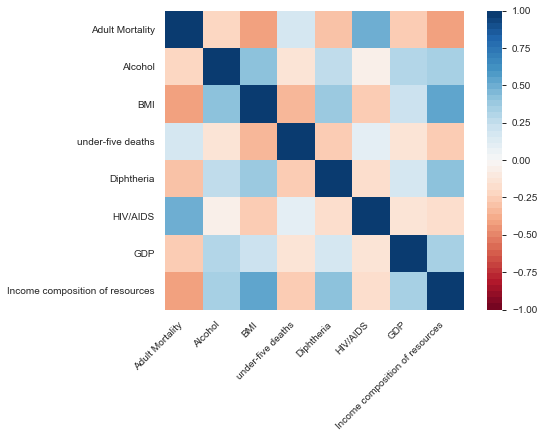

In [48]:
corr = datos[selected_cols2].corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.color_palette("RdBu",50),
    square=True,
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

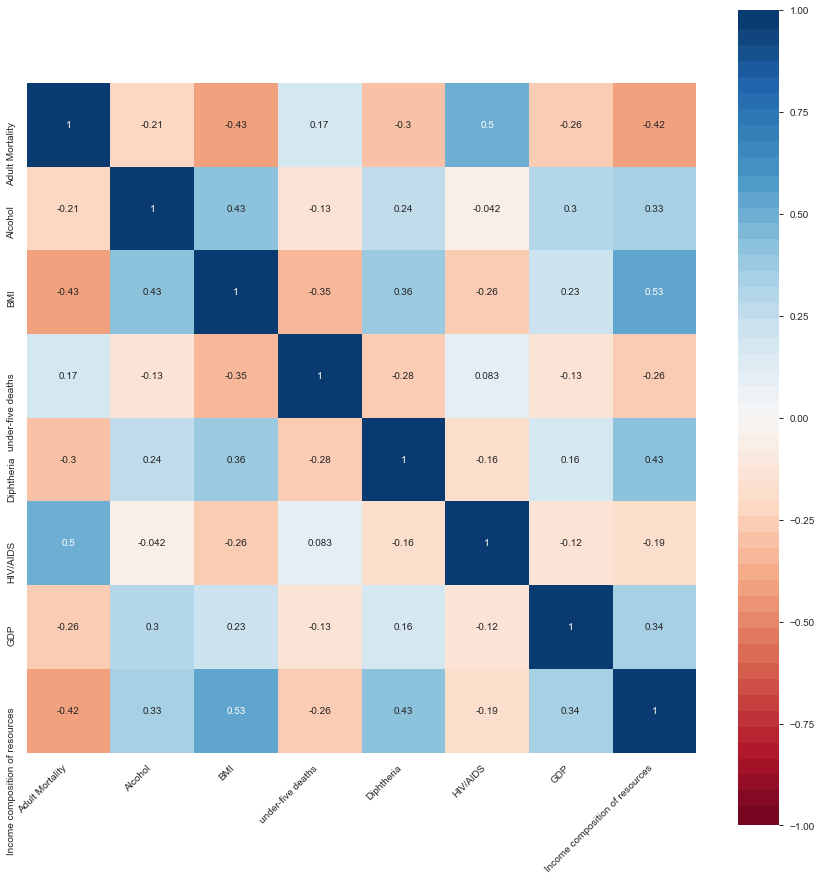

In [49]:
plt.figure(figsize =(15,15))
corr = datos[selected_cols2].corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.color_palette("RdBu",50),
    square=True,
    annot = True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Se cumple el supuesto

#### Linealidad
Es necesario que la relación entre cada variable explicativa y la varable objetivo sea lineal. Muchas veces la mejor forma de ahcer esto es visualmente:

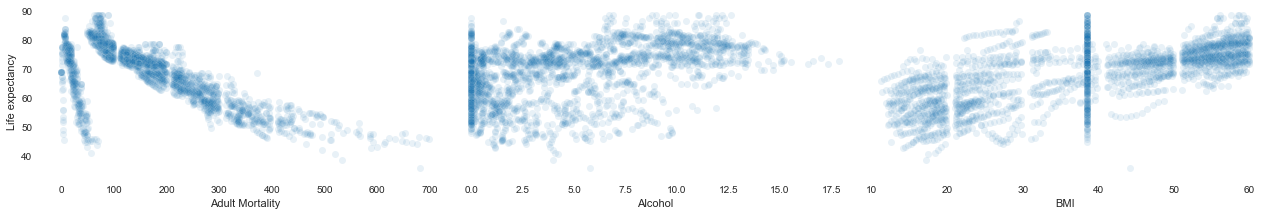

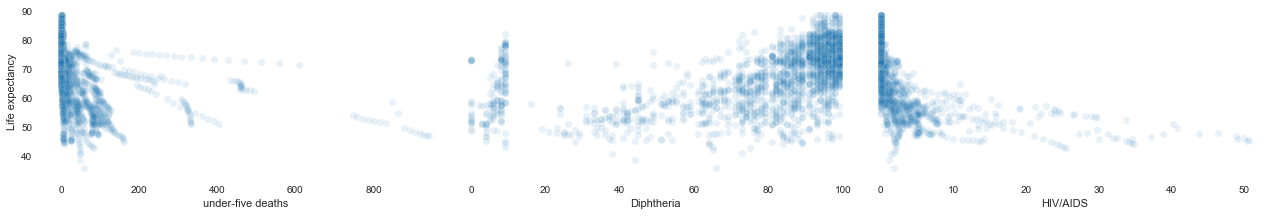

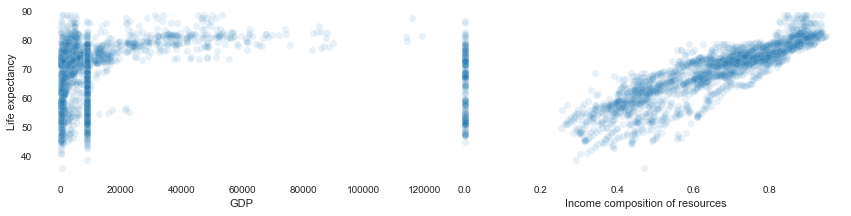

In [50]:
sns.pairplot(datos, height=3, aspect = 2, y_vars = 'Life expectancy', x_vars = selected_cols2[0:3], kind='scatter', plot_kws = {'alpha':0.1})
sns.pairplot(datos, height=3, aspect = 2, y_vars = 'Life expectancy', x_vars = selected_cols2[3:6], kind='scatter', plot_kws = {'alpha':0.1})
sns.pairplot(datos, height=3, aspect = 2, y_vars = 'Life expectancy', x_vars = selected_cols2[6:], kind='scatter', plot_kws = {'alpha':0.1})

In [51]:
# hacer algo respecto a esto ....

In [52]:
for col in selected_cols2:
    X = datos[[col]].copy()
    X2 = datos[[col]].copy()
    col_name2 = col + str(2)
    X2[col_name2] = X[col]**2
    X[col_name2] = X[col]
    
    model = [('initial',ColumnTransformer([("selector", 'passthrough',[col_name2])])),
             ('imputer', SimpleImputer(missing_values = np.nan, strategy='median')),
             ('scaler', MinMaxScaler()),
             ('model',LinearRegression())]
    
    p_temp = Pipeline(model)
    
    p_temp = p_temp.fit(X,y)
    p_temp2 = p_temp.fit(X2,y)
    print(f"{col}: {p_temp.score(X,y)}", p_temp2.score(X2,y))

Adult Mortality: -0.23146375272012465 0.48980334339868115
Alcohol: -0.037700843308586585 0.15182483152739867
BMI: -0.8757045264702363 0.368121019425233
under-five deaths: -0.0006442316701897877 0.03683513766602564
Diphtheria: -2.1490922813763254 0.3388369546737563
HIV/AIDS: 0.007446006444388531 0.10005359622926524
GDP: -0.0068345047733666675 0.08740167962089807
Income composition of resources: 0.07453881826563258 0.5971383464697065


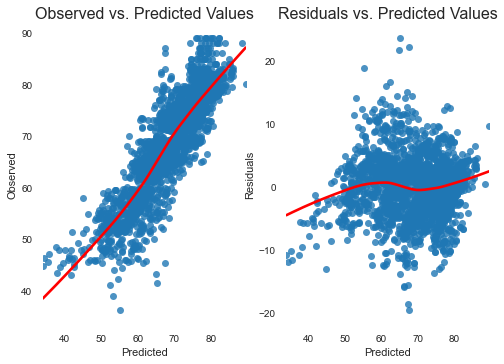

In [58]:
X=datos[selected_cols2]
def linearity_test(model, y, X):
    '''
    Function for visually inspecting the assumption of linearity in a linear regression model.
    It plots observed vs. predicted values and residuals vs. predicted values.
    
    Args:
    * model - fitted OLS model from statsmodels
    * y - observed values
    '''
    fitted_vals = model.predict(X)
    resids = (fitted_vals - y)

    fig, ax = plt.subplots(1,2)
    
    sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Observed vs. Predicted Values', fontsize=16)
    ax[0].set(xlabel='Predicted', ylabel='Observed')

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Residuals vs. Predicted Values', fontsize=16)
    ax[1].set(xlabel='Predicted', ylabel='Residuals')
    
linearity_test(p2, y, X)   

El resultado deseado es que, con una varianza constante, los puntos se distribuyan simétricamente alrededor de una línea diagonal en el primer gráfico o alrededor de una línea horizontal en el último. 
La observación de un patrón 'arqueado' indica que el modelo comete errores sistemáticos cada vez que hace predicciones inusualmente grandes o pequeñas.

#### Normalidad en los Errores

Otra suposición de la regresión lineal es que los errores tienen una distribución normal. Para esto se puede usar:

* Grafico de dispersión entre los errores y el valor predicto
* Grafico Q-Q

In [63]:
def grafica_normalidad_errores(p2, X, y):
        # Calculamos los errores
    errors = (p2.predict(X) - y).values

    fig, axes = plt.subplots(1, 2, figsize = (12,4))

    # Dispersión
    sns.scatterplot(x = p2.predict(X), y = errors, alpha = 0.1, ax = axes[0])

    # q-q plot
    _ = stats.probplot(errors, dist="norm", plot=axes[1])

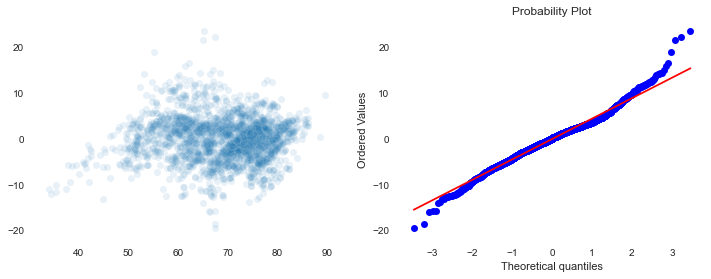

In [60]:
X = datos.drop('Life expectancy', axis = 1)
y = datos['Life expectancy']
grafica_normalidad_errores(p2, X, y)


En la primera gráfica, se ve que los errores estan centrados en cero, pero no se distribuyen de la misma manera en la gráfica. Por otro lado, al obtener el gráfico Q-Q, podemos decir que al parecer los errores si siguen una distribución normal (media 0 y desviación estandar de 1). Sin embargo, para estar seguros, haremos el histograma de los errores y realizaremos una prueba de normalidad (Kolmogorov–Smirnov)

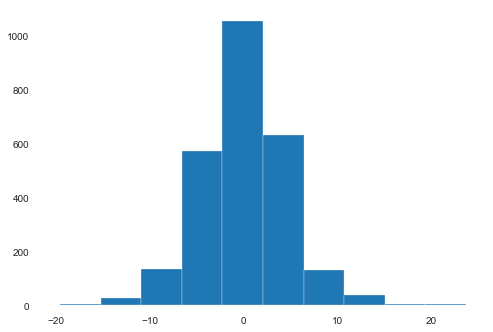

In [64]:
errors= (p2.predict(X) - y).values
plt.hist(errors)
plt.show()

Vemos que los errores están centrados en cero y que, efectivamente parece que tuvieran una distrubución normal. Ahora realizaremos la prueba. 

In [65]:
statistc, pvalue=stats.kstest(errors, "norm")
print ("Estadística", statistc, " p-value", pvalue)
if pvalue<0.05: print("La hipótesis nula se rechaza, no sigue una distribución normal")
else :print("La hipótesis nula se acepta")

Estadística 0.3051548707471665  p-value 2.716436316876866e-215
La hipótesis nula se rechaza, no sigue una distribución normal


Con este resultado, eliminaremos los outliers de la variable de interés en caso de que estos existan

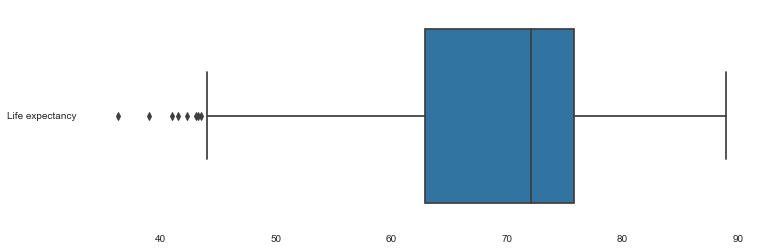

In [66]:
# Diagrama de caja
fig=plt.figure(figsize=(12,4))
ax = sns.boxplot(data= datos[['Life expectancy']], orient="h")

Vemos que hay outliers en el limite inferior, asi que esos serán los que vamos a borrar

In [67]:
#IQR = Q3-Q1
#+/- IQR*1.5
q1=datos['Life expectancy'].quantile(0.25)
q3=datos['Life expectancy'].quantile(0.75)
iqr= q3-q1
lower_bound=q1-1.5*iqr
datos.drop(datos[datos["Life expectancy"]<lower_bound].index, inplace=True)

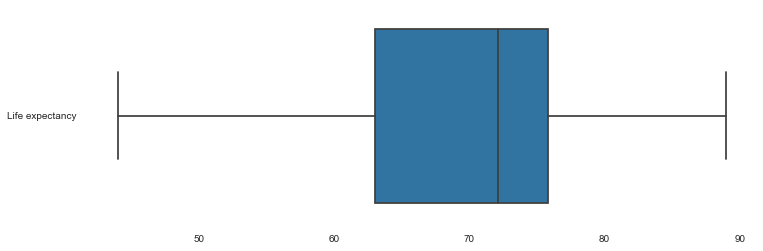

In [68]:
# Diagrama de caja
fig=plt.figure(figsize=(12,4))
ax = sns.boxplot(data= datos[['Life expectancy']], orient="h")

Volvemos a realizar el modelo. y volvemos a comprobar este supuesto

In [69]:
selected_cols3=selected_cols2

X = datos.drop('Life expectancy', axis = 1)
y = datos['Life expectancy']

#Debido a que el algoritmo que usaremos para la construcción del modelo es Regresión Linear, debemos realizar escalamiento de los datos, por lo que procedemos con lo siguiente
pre = [('initial',ColumnTransformer([("selector", 'passthrough',selected_cols3)])),
       ('scaler', MinMaxScaler()),
       ('imputer', SimpleImputer(missing_values = np.nan, strategy='mean')),
      ]
# Modelo
model = [('model', LinearRegression())]

# Se declara el pipeline
pipeline3 = Pipeline(pre+model)
p3 = pipeline3.fit(X,y)

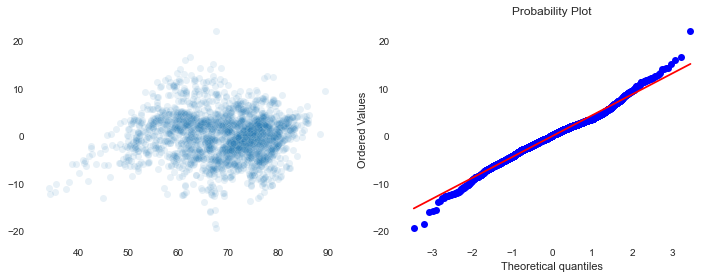

In [70]:
grafica_normalidad_errores(p3, X, y)

In [71]:
statistc, pvalue=stats.kstest(errors, "norm")
print ("Estadística", statistc, " p-value", pvalue)
if pvalue<0.05: print("La hipótesis nula se rechaza, no sigue una distribución normal")
else :print("La hipótesis nula se acepta")

Estadística 0.3051548707471665  p-value 2.716436316876866e-215
La hipótesis nula se rechaza, no sigue una distribución normal


Al hacer este cambio no hay mejoras 

#### Varianza Constante (Homocedasticidad)

<AxesSubplot:xlabel='Life expectancy'>

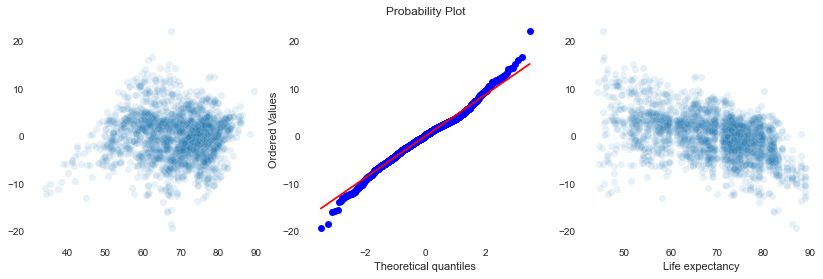

In [72]:
# Visualizamos nuestros datos
# Revisamos las graficas

# Calculamos los errores
errors = (p3.predict(X) - y).values

fig, axes = plt.subplots(1, 3, figsize = (14,4))

# Dispersión
sns.scatterplot(x = p3.predict(X), y = errors, alpha = 0.1, ax = axes[0])

# q-q plot
_ = stats.probplot(errors, dist="norm", plot=axes[1])

sns.scatterplot(data  = datos, x = 'Life expectancy', y = errors, alpha = 0.1, ax = axes[2])

### Interpretación de los coeficientes
realice una interpretación de los coeficientes de la regresión, identificando los mas relevantes para la tarea y como afectan la variable objetivo.


In [73]:
modelo_regresion=p3["model"]
x=datos[selected_cols3]
importancia = modelo_regresion.coef_
importancia_atributo = pd.DataFrame(data={"Atributo": x.columns,"Importancia": importancia})
importancia_atributo = importancia_atributo.sort_values(by='Importancia', ascending=False).reset_index(drop=True)
importancia_atributo

,Atributo,Importancia
0,GDP,9.255304
1,Income composition of resources,8.518028
2,Diphtheria,5.869273
3,BMI,5.851401
4,Alcohol,3.744157
5,under-five deaths,-8.764483
6,Adult Mortality,-15.623434
7,HIV/AIDS,-24.519602


El valor de un coeficiente determina cuánto aumenta o se reduce el valor promedio de la variable dependiente cuando la independiente cambia por una unidad. El signo del coeficiente indica si la relación es positiva o negativa. Daremos un ejemplo para una que tenga coeficiente positivo y otra con coeficiente negativo.  
* Cuando aumenta el valor de la expectativa de vida en unidad, aumenta asimismo el GDP por 9.25.
* Cuando aumenta el valor de la expectativa de vida en unidad, disminuye asimismo el HIV/AIDS en aproximadamente 24.

## Exportar el modelo: 
Su equipo debe exportar el modelo para poder ser usado sobre datos recientes en el ambiente de producción del cliente.

In [31]:
import joblib
joblib.dump(p2, 'ModeloRegresion.joblib')


NameError: name 'p2' is not defined